In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, make_scorer

# Decision tree with cross validation:
from sklearn.tree import DecisionTreeClassifier as dtc # tree algorithm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold

from tqdm.notebook import tqdm
from multiprocess import Pool

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading data:

In [2]:
# Load certificate lengths from MTA and Tranco
mta2020_certs_merge = pd.read_csv('processed-datasets/mta2020_certs_merge.csv', engine='python')
tranco_df = pd.read_csv('processed-datasets/tranco-dataset.csv', engine='python')

In [3]:
tranco_df

,c_ip,c_port,s_ip,s_port,ip_proto,start_time,c_tls_version,s_tls_version,c_supported_versions,s_supported_versions,c_psk_present,c_psk_kem,s_psk,hello_retry_req,tls_b_0,tls_b_1,tls_b_2,tls_b_3,tls_b_4,tls_b_5,tls_b_6,tls_b_7,tls_b_8,tls_b_9,tls_b_10,tls_b_11,tls_b_12,tls_b_13,tls_b_14,tls_b_15,tls_b_16,tls_b_17,tls_b_18,tls_b_19,tls_ipt_0,tls_ipt_1,tls_ipt_2,tls_ipt_3,tls_ipt_4,tls_ipt_5,tls_ipt_6,tls_ipt_7,tls_ipt_8,tls_ipt_9,tls_ipt_10,tls_ipt_11,tls_ipt_12,tls_ipt_13,tls_ipt_14,tls_ipt_15,tls_ipt_16,tls_ipt_17,tls_ipt_18,tls_ipt_19,tls_dir_0,tls_dir_1,tls_dir_2,tls_dir_3,tls_dir_4,tls_dir_5,tls_dir_6,tls_dir_7,tls_dir_8,tls_dir_9,tls_dir_10,tls_dir_11,tls_dir_12,tls_dir_13,tls_dir_14,tls_dir_15,tls_dir_16,tls_dir_17,tls_dir_18,tls_dir_19,tls_tp_0,tls_tp_1,tls_tp_2,tls_tp_3,tls_tp_4,tls_tp_5,tls_tp_6,tls_tp_7,tls_tp_8,tls_tp_9,tls_tp_10,tls_tp_11,tls_tp_12,tls_tp_13,tls_tp_14,tls_tp_15,tls_tp_16,tls_tp_17,tls_tp_18,tls_tp_19,sni,s_cert_lengths,source,file,tls_version_guess,cert_size_guess_simple,total_s_cert
0,172.19.22.2,57044,1.0.0.3,443,6,1.706618e+09,5,5,-1,-1,0,-1,-1,0,201,76,2939,115,4,37,1,40,202,1,40,64,189,26,-1,-1,-1,-1,-1,-1,0,24,0,2,0,238,0,0,21,0,0,0,0,0,-1,-1,-1,-1,-1,-1,0,1,1,1,1,0,0,0,1,1,1,1,0,0,-1,-1,-1,-1,-1,-1,22,22,22,22,22,22,20,22,22,20,22,23,23,21,-1,-1,-1,-1,-1,-1,family.cloudflare-dns.com,1654:1272,tranco,shuf_tranco000_tls12_2024_01_30_12h40,TLS 1.2,-1.0,2926
1,172.19.22.2,57072,1.0.0.3,443,6,1.706618e+09,5,5,-1,-1,0,-1,-1,0,201,76,2939,116,4,37,1,40,202,1,40,64,189,26,33,-1,-1,-1,-1,-1,0,28,0,4,0,230,0,0,21,0,0,0,0,0,20,-1,-1,-1,-1,-1,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,-1,-1,-1,-1,-1,22,22,22,22,22,22,20,22,22,20,22,23,23,21,23,-1,-1,-1,-1,-1,family.cloudflare-dns.com,1654:1272,tranco,shuf_tranco000_tls12_2024_01_30_12h40,TLS 1.2,NaN,2926
2,172.19.22.2,35098,192.0.77.40,443,6,1.706618e+09,5,5,-1,-1,0,-1,-1,0,186,82,3126,289,115,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,49,0,2,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,22,22,22,22,22,22,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,tumblr.com,1187:940:983,tranco,shuf_tranco000_tls12_2024_01_30_12h40,TLS 1.2,NaN,3110
3,172.19.22.2,58110,23.47.188.208,443,6,1.706618e+09,5,5,-1,-1,0,-1,-1,0,192,78,4134,1596,333,4,70,1,40,202,1,40,172,63,33,33,-1,-1,-1,-1,0,22,0,4,19,0,0,0,0,21,0,0,0,21,0,0,-1,-1,-1,-1,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,0,-1,-1,-1,-1,22,22,22,22,22,22,22,20,22,22,20,22,23,23,23,23,-1,-1,-1,-1,www.t-mobile.com,1730:1298:1090,tranco,shuf_tranco000_tls12_2024_01_30_12h40,TLS 1.2,NaN,4118
4,172.19.22.2,50672,15.72.80.135,443,6,1.706618e+09,5,5,-1,-1,0,-1,-1,0,182,91,4422,333,4,70,1,40,1,40,438,26,361,250,-1,-1,-1,-1,-1,-1,0,183,0,4,0,0,0,0,181,0,104,36,153,0,-1,-1,-1,-1,-1,-1,0,1,1,1,1,0,0,0,1,1,0,0,1,1,-1,-1,-1,-1,-1,-1,22,22,22,22,22,22,20,22,20,22,23,21,23,23,-1,-1,-1,-1,-1,-1,hp.com,2264:1228:914,tranco,shuf_tranco000_tls12_2024_01_30_12h40,TLS 1.2,NaN,4406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505933,172.19.22.3,32934,104.22.56.216,443,6,1.706544e+09,5,5,20304,304,0,101,-1,0,596,122,1,3949,1,53,182,2074,182,1,53,19,-1,-1,-1,-1,-1,-1,-1,-1,0,122,0,0,10,0,0,58,24,49,0,1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,1,0,0,0,1,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,22,22,20,23,20,23,23,229,23,20,23,23,-1,-1,-1,-1,-1,-1,-1,-1,static.cardmarket.com,-1,tranco,tranco001_tls13_2024_01_29_14h59,TLS 1.3,3800.0,-1
505934,172.19.22.3,32942,104.22.56.216,443,6,1.706544e+09,5,5,20304,304,0,101,-1,0,596,122,1,3949,1,53,182,30410,182,19,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,137,0,0,7,0,0,52,28,43,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,1,0,0,0,1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-

In [4]:
mta2020_certs_merge['source']='MTA'

# We need to add 3 to each certificate size to match the result given by Wireshark.
tranco_df['tls.handshake.certificates_length'] = tranco_df['s_cert_lengths'].map(lambda x: sum([x+3 if x!=-1 else x for x in map(int,str(x).split(':'))]))
tranco_df['c2'] = 0

In [5]:
# defining groups for train/test splitting:
mta2020_certs_merge['file'] = mta2020_certs_merge['fileindex']

tranco_df['file_cat'] = tranco_df['file'].astype('category')
tranco_df['file'] = tranco_df['file_cat'].cat.codes
tranco_df['file'] = tranco_df['file'] + 10000

In [6]:
all_certs = pd.concat([
    mta2020_certs_merge[['tls.handshake.certificates_length', 'c2', 'source', 'file']],
    tranco_df[['tls.handshake.certificates_length', 'c2', 'source', 'file']]
    ])
display(all_certs)

,tls.handshake.certificates_length,c2,source,file
0,847,0.0,MTA,4
1,847,0.0,MTA,4
2,847,0.0,MTA,4
3,847,0.0,MTA,4
4,847,0.0,MTA,4
...,...,...,...,...
505933,-1,0.0,tranco,11999
505934,-1,0.0,tranco,11999
505935,-1,0.0,tranco,11999
505936,-1,0.0,tranco,11999


In [7]:
# exclude sessions without valid certificates:
valid_certs = all_certs[all_certs['tls.handshake.certificates_length'] != -1]
print(len(valid_certs))

258478


In [8]:
valid_certs.reset_index(drop=True, inplace=True)

In [9]:
# Take ~20% of Tranco and MTA for final testing. These should be taken considering groups.
# This can pottentially make 5 folds, and the experiment could be repeated.
# Worth doing, or just do this single experiment?

# X and Y composed only of MTA and Tranco 1.2.
# StratifiedGroupKFold to take 20% out for final testing.
x = valid_certs.loc[:,['tls.handshake.certificates_length']].values.astype(np.float64)
y = valid_certs['c2'].values
groups = valid_certs['file'].values

In [10]:
sgkf = StratifiedGroupKFold(n_splits=5)
# Take 1 fold/split, as our traing/test split:
train_index, test_index = next(sgkf.split(x, y, groups))
# groups = groups[train_index]

In [11]:
# These are used with Cross Validation to train RFCs and DecTrees. CV should be sgkf as well.
# Using CV we will choose the best parameters (tree depth, number of estimators, whatever...),
# and then use those parameters to train a "final model", that we will apply to the "test set".
train_df = shuffle(pd.concat([
    valid_certs.loc[train_index]
], ignore_index=True), random_state=42).reset_index(drop=True)

display(train_df['source'].value_counts())

x_train = train_df.loc[:,['tls.handshake.certificates_length']].values.astype(np.float64)
y_train = train_df['c2'].values
groups_train = train_df['file'].values

source
tranco    176468
MTA        30462
Name: count, dtype: int64

In [12]:
# loading ms cert sizes:
ms_certs_length = pd.read_csv('data/ms/certificates_length.csv')
ms_certs_length['c2'] = 1
ms_certs_length['source'] = 'MS'
ms_certs_length['file'] = ms_certs_length.groupby(['command', 'tlsver', 'certver']).ngroup() + 20000
ms_certs_length

,frame.time_epoch,ip.src,tcp.srcport,ip.dst,tcp.dstport,tls.handshake.certificates_length,tlsver,certver,command,c2,source,file
0,1.649254e+09,172.18.0.3,443,172.18.0.2,57008,2547,tls12,longcert,multiple,1,MS,20024
1,1.649254e+09,172.18.0.3,443,172.18.0.2,57010,2547,tls12,longcert,multiple,1,MS,20024
2,1.649254e+09,172.18.0.3,443,172.18.0.2,57012,2547,tls12,longcert,multiple,1,MS,20024
3,1.649254e+09,172.18.0.3,443,172.18.0.2,57014,2547,tls12,longcert,multiple,1,MS,20024
4,1.649254e+09,172.18.0.3,443,172.18.0.2,57016,2547,tls12,longcert,multiple,1,MS,20024
...,...,...,...,...,...,...,...,...,...,...,...,...
2373673,1.649341e+09,172.18.0.3,443,172.18.0.2,54858,1004,tls13,shortcert,sysinfo,1,MS,20043
2373674,1.649341e+09,172.18.0.3,443,172.18.0.2,54860,1004,tls13,shortcert,sysinfo,1,MS,20043
2373675,1.649341e+09,172.18.0.3,443,172.18.0.2,54862,1004,tls13,shortcert,sysinfo,1,MS,20043
2373676,1.649341e+09,172.18.0.3,443,172.18.0.2,54864,1004,tls13,shortcert,sysinfo,1,MS,20043


In [13]:
ms13_cert_inf = pd.read_csv('processed-datasets/ms-tls13-cert-inf.csv', engine='python', index_col=0)
ms13_cert_inf

,command,tlsver,certver,cert_size_guess_simple
0,route,tls13,shortcert,950.0
1,route,tls13,shortcert,950.0
2,route,tls13,shortcert,950.0
3,route,tls13,shortcert,950.0
4,route,tls13,shortcert,950.0
...,...,...,...,...
394896,ps,tls13,longcert,2565.0
394897,ps,tls13,longcert,2565.0
394898,ps,tls13,longcert,2565.0
394899,ps,tls13,longcert,2565.0


In [14]:
# For the test set, we should display results separated by (sub)datasets:
# Tranco 1.2/1.3 (TNRs); MTA (TPR, TNR); MS 1.2/1.3 short/long (TPRs); DoH? (TNR)
tranco_test = {
    12: valid_certs.loc[test_index][(valid_certs.loc[test_index, 'source'] == 'tranco')].loc[:,['tls.handshake.certificates_length']].values.astype(np.float64),
    13: tranco_df.loc[(tranco_df['tls_version_guess'] == 'TLS 1.3')&(tranco_df['s_psk'] == -1), ['cert_size_guess_simple']].values.astype(np.float64),
}
mta_test = valid_certs.loc[test_index][valid_certs.loc[test_index, 'source'] == 'MTA'].loc[:,['tls.handshake.certificates_length']].values.astype(np.float64)
mta_test_y = valid_certs.loc[test_index][valid_certs.loc[test_index, 'source'] == 'MTA'].loc[:,'c2'].values

ms_test = {
    12: {"short": ms_certs_length.loc[(ms_certs_length['tlsver'] == 'tls12') & (ms_certs_length['certver'] == 'shortcert'), ['tls.handshake.certificates_length']].values.astype(np.float64),
         "long":  ms_certs_length.loc[(ms_certs_length['tlsver'] == 'tls12') & (ms_certs_length['certver'] == 'longcert'), ['tls.handshake.certificates_length']].values.astype(np.float64)},
    13: {"short": ms13_cert_inf.loc[(ms13_cert_inf['tlsver'] == 'tls13') & (ms13_cert_inf['certver'] == 'shortcert'), ['cert_size_guess_simple']].values.astype(np.float64),
         "long":  ms13_cert_inf.loc[(ms13_cert_inf['tlsver'] == 'tls13') & (ms13_cert_inf['certver'] == 'longcert'), ['cert_size_guess_simple']].values.astype(np.float64)}
}

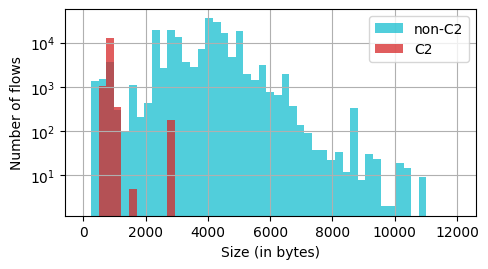

In [15]:
fig = plt.figure(figsize = (5,2.8), facecolor='white'); ax = fig.gca()
train_df[train_df['c2']==0].hist(column='tls.handshake.certificates_length', bins=np.linspace(0, 12000, 50), log=True, ax=ax, alpha=0.75, label='non-C2', color='tab:cyan')
train_df[train_df['c2']==1].hist(column='tls.handshake.certificates_length', bins=np.linspace(0, 12000, 50), log=True, ax=ax, alpha=0.75, label='C2', color='tab:red')
ax.title.set_visible(not ax.title.get_visible())
ax.set_xlabel('Size (in bytes)')
ax.set_ylabel('Number of flows')
plt.legend(loc='upper right')
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs=(1.0,)))
plt.gca().yaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))
plt.tight_layout()
plt.show()
#plt.savefig("exports/server_cert_sizes2.pdf", bbox_inches='tight')

In [16]:
test_mta_df = mta2020_certs_merge[mta2020_certs_merge['tls.handshake.certificates_length'] != -1].iloc[[i for i in test_index if i < 36435]]
test_mta_df

,frame.time_epoch,ip.src,tcp.srcport,ip.dst,tcp.dstport,tls.handshake.certificates_length,fileindex,s_ip,s_port,c_ip,c_port,file,c2,cert_fp,new_label,source
133,1.393383e+09,173.194.77.104,443,192.168.204.175,49392,3084,51,NaN,NaN,NaN,NaN,51,0.0,NaN,NaN,MTA
143,1.399094e+09,134.170.104.112,443,192.168.204.223,49525,5709,118,NaN,NaN,NaN,NaN,118,0.0,NaN,NaN,MTA
150,1.399244e+09,173.194.67.105,443,192.168.204.226,49273,3084,120,NaN,NaN,NaN,NaN,120,0.0,NaN,NaN,MTA
151,1.399244e+09,173.194.67.105,443,192.168.204.226,49274,3084,120,NaN,NaN,NaN,NaN,120,0.0,NaN,NaN,MTA
152,1.399244e+09,173.194.67.105,443,192.168.204.226,49275,3084,120,NaN,NaN,NaN,NaN,120,0.0,NaN,NaN,MTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1.597092e+09,217.165.112.13,995,172.16.10.101,56520,797,2333,NaN,NaN,NaN,NaN,2333,0.0,NaN,NaN,MTA
36431,1.597092e+09,52.185.211.133,443,172.16.10.101,56521,3279,2333,NaN,NaN,NaN,NaN,2333,0.0,NaN,NaN,MTA
36432,1.597092e+09,13.107.5.88,443,172.16.10.101,56522,3892,2333,NaN,NaN,NaN,NaN,2333,0.0,NaN,NaN,MTA
36433,1.597093e+09,217.165.112.13,995,172.16.10.101,56525,797,2333,NaN,NaN,NaN,NaN,2333,0.0,NaN,NaN,MTA


In [17]:
test_mta_df[test_mta_df['c2']==0]['tls.handshake.certificates_length'].value_counts()

tls.handshake.certificates_length
968     239
3977    110
4414    103
2531     75
793      65
       ... 
889       1
5405      1
3119      1
4739      1
4523      1
Name: count, Length: 562, dtype: int64

In [18]:
doh_df = pd.read_csv('data/doh/joy-tls-versions-certinf-joypatched.csv')
x_certs_doh = doh_df[(doh_df['tls_version_guess'] == 'TLS 1.3') & (doh_df['s_psk'] == -1)]['cert_size_guess_simple'].values.astype(np.float64).reshape(-1,1)

/tmp/ipykernel_2460/3668868768.py:1: DtypeWarning: Columns (8,94) have mixed types. Specify dtype option on import or set low_memory=False.
  doh_df = pd.read_csv('data/doh/joy-tls-versions-certinf-joypatched.csv')


In [19]:
doh_df['c2'] = 0
doh_df.loc[doh_df['file'].str.startswith('e') |
           doh_df['file'].str.startswith('f') |
           doh_df['file'].str.startswith('g'), 'c2'] = 1

In [20]:
doh_df_all_benign = doh_df.loc[(doh_df['tls_version_guess'] == 'TLS 1.3') & (doh_df['s_psk'] == -1) & (doh_df['c2'] == 0) & (doh_df['cert_size_guess_simple'] != -1), ['cert_size_guess_simple']].values.astype(np.float64)
doh_df_all_malicious = doh_df.loc[(doh_df['tls_version_guess'] == 'TLS 1.3') & (doh_df['s_psk'] == -1) & (doh_df['c2'] == 1) & (doh_df['cert_size_guess_simple'] != -1), ['cert_size_guess_simple']].values.astype(np.float64)

## Training

In [21]:
scoring = {"AUC": "roc_auc",
           "Accuracy": "accuracy",
           "Balanced Accracy": "balanced_accuracy",
           "Recall": "recall",
           "Neg Recall": make_scorer(recall_score, pos_label=0),
           "F1": "f1"}

In [22]:
sgkf = StratifiedGroupKFold(n_splits=10)

In [23]:
# This error list comes from the Curl experiments
diff_list = np.array([ -23,  -22,  -39,    0,    0,    0,    0,    0, -211,    0,    0,
                        -22,  -40,  -26,    0,  -26,    0,    0,    0, -207, -211,    0,
                        -26,    0,    0,    0,    0,    0,  -41,    0,    0,    0,  -21,
                       -207,    0, -211, -207,    0,  -23,    0,  -22,  -23,    0,    0,
                          0,    0,    0,  -26,    0,    0,    0,    0, -211,    0,    0,
                        -21,    0,  -23, -207,    0,    0,  -23,    0,    0,    0,  -26,
                        -21,    0,    0,    0,  -25,  -22,    0,  -26,  -22,    0,  -25,
                        -22, -211,    0,    0,  -22, -211,    0,    0,    0,    0,    0,
                          0, -211, -207, -207,    0, -207,    0,    0,  -26,    0,  -25,
                          0, -207,    0,    0,    0,    0,  -22,    0,  -22,    0,    0,
                          0,    0,    0,    0,    0,  -26,  -23,    0,  -26,  -25,    0,
                          0,  -26,    0,  -26,    0, -467,  -21,    0,    0,  -26,    0,
                          0,  -22,    0,    0,    0,    0,    0,    0,    0,    0,  -26,
                          0,    0,  -26,  -22,  -23,    0,    0,    0,    0,    0, -207,
                        -22,    0,  -23,    0,  -25,    0,    0, -217,  -27,    0,    0,
                          0,  -26,    0,    0,    0, -211,    0,  -22,    0,    0,    0,
                          0,  -26,    0,    0,    0,    0,  -25,    0,    0,  -26,  -26,
                          0, -211,  -26,    0,  -26,    0,  -21,  -21,  -26,    0,    0,
                          0,    0, -207, -207,    0,    0,    0, -211,  -26,    0, -207,
                          0,  -26,  -26,    0,    0,    0,  -26,  -25,  -25,    0,    0,
                          0,    0,    0,  -22,    0,    0, -211,    0,    0,    0,  -25,
                        -26,    0,  -26,    0,    0,    0,  -25,    0,  -26,    0,  -27,
                        -26,    0, -207,    0, -207,    0,    0,    0,    0,    0,  -26,
                          0, -207,  -25,    0,    0,    0,    0,    0,    0,    0, -207,
                        -26,  -27,    0,  -27,  -26,    0,  -23,    0,    0,  -27, -207,
                          0,  -27,    0,    0,    0,    0, -211,  -26,  -23,    0,    0,
                          0,  -22,    0,  -23,    0, -211,  -26,    0, -211,    0,    0,
                       -211, -211,  -26,  -26,    0,  -25, -211,  -26,  -22,    0,    0,
                       -207,  -22,    0,    0,    0,  -26,    0, -207,  -27,    0,    0,
                          0,    0,    0,  -26,  -22, -207,    0,    0,  -23, -211,  -26,
                          0,  -25,    0,  -26, -211,    0, -211,  -27,    0,    0,    0,
                          0,  -22,  -26,  -26,    0,    0,    0,    0,    0,    0, -207,
                       -207,  -26,    0, -211,  -25,  -25,    0,    0, -211,    0,    0,
                          0,    0, -207,  -27,  -27,    0,  -25,    0,    0, -207,    0,
                        -26,    0, -211,    0,  -27,    0,    0,  -25,    0,    0,  -26,
                        -25,  -26,    0,  -26,    0,    0,    0,    0,    0,  -25,    0,
                        -26,    0, -207,  -26,    0,    0,    0,    0,  -26,    0,    0,
                          0,  -26, -211,    0,  -25,    0, -211, -211, -207,    0, -211,
                        -26,    0,  -22,    0,    0,  -27, -207,  -21,  -26,  -25,    0,
                        -26,    0,    0,  -26,  -26,  -27, -211,    0,    0,  -27,    0,
                          0,    0,    0,    0,    0,    0,  -27,  -27,    0,  -25,    0,
                          0,    0,  -26,  -27,  -26,    0,    0,    0,    0,    0,    0,
                       -207,  -23,  -25,    0,    0, -211,  -25,    0, -211,    0,    0,
                          0,  -26,    0,  -22,    0,  -26,    0,    0, -211,  -26,  -26,
                        -26,    0,  -25,    0,    0,  -26])
np.random.seed(0)
print(np.random.choice(diff_list))
print(np.min(diff_list))

-22
-467


In [24]:
x_train_diff = np.copy(x_train)
for i in range(len(x_train_diff)):
    x_train_diff[i][0] -= np.random.choice(diff_list)

In [25]:
x_train_diff2, y_train2, groups_train2 = shuffle(np.concatenate([x_train_diff, x_train]),
                                                 np.concatenate([y_train, y_train]),
                                                 np.concatenate([groups_train, groups_train]))

In [22]:
# Skip this if not performing grid search again!
# Optimize for Recall
# If a random splitter is used, it finds a model that flags
# everything as positive (100% recall)
dtc_classifier = dtc(random_state=42)
parameters = {'max_depth':list(range(1,20))+[30,40,50,60], 
              'criterion': ['gini', 'entropy'], 
              #'splitter': ['best', 'random'],
              'class_weight': [None, 'balanced']}

clf_recall = GridSearchCV(dtc_classifier, parameters, n_jobs=-1, scoring=scoring, refit='Recall', cv=sgkf)
clf_recall.fit(x_train_diff2, y_train2, groups=groups_train2)
print(clf_recall.best_score_, clf_recall.best_params_)

0.9838644605179621 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1}


In [26]:
# 0.9838644605179621 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1}
clf_recall = dtc(random_state=42, class_weight='balanced', criterion='gini', max_depth=1)
clf_recall.fit(x_train_diff2, y_train2)

DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=42)

In [27]:
print(" & ".join('{:.2f}'.format(x) for x in [ 
                   sum(clf_recall.predict(mta_test)[np.where(mta_test_y==0)] == 0) / sum(mta_test_y==0) *100,
                   sum(clf_recall.predict(mta_test)[np.where(mta_test_y)]) / sum(mta_test_y) *100,
                   sum(clf_recall.predict(tranco_test[12])==0)/len(tranco_test[12]) * 100,
                   sum(clf_recall.predict(tranco_test[13])==0)/len(tranco_test[13]) * 100,
                   sum(clf_recall.predict(ms_test[12]["short"])==1)/len(ms_test[12]["short"]) * 100,
                   sum(clf_recall.predict(ms_test[12]["long"])==1)/len(ms_test[12]["long"]) * 100,
                   sum(clf_recall.predict(ms_test[13]["short"])==1)/len(ms_test[13]["short"]) * 100,
                   sum(clf_recall.predict(ms_test[13]["long"])==1)/len(ms_test[13]["long"]) * 100,
                   sum(clf_recall.predict(doh_df_all_benign)==0)/len(doh_df_all_benign) * 100
]))

56.61 & 98.89 & 99.73 & 94.91 & 100.00 & 0.00 & 100.00 & 0.00 & 99.61


In [28]:
print(" & ".join('{:.2f}'.format(x) for x in [ 
                   sum(clf_recall.predict(mta_test)[np.where(mta_test_y==0)] == 0) / sum(mta_test_y==0) *100,
                   sum(clf_recall.predict(mta_test)[np.where(mta_test_y)]) / sum(mta_test_y) *100,
                   sum(clf_recall.predict(tranco_test[12])==0)/len(tranco_test[12]) * 100,
                   sum(clf_recall.predict(ms_test[12]["short"])==1)/len(ms_test[12]["short"]) * 100,
                   sum(clf_recall.predict(ms_test[12]["long"])==1)/len(ms_test[12]["long"]) * 100,
]))

56.61 & 98.89 & 99.73 & 100.00 & 0.00


In [29]:
print(" & ".join('{:.2f}'.format(x) for x in [
                   sum(clf_recall.predict(tranco_test[13])==0)/len(tranco_test[13]) * 100,
                   sum(clf_recall.predict(ms_test[13]["short"])==1)/len(ms_test[13]["short"]) * 100,
                   sum(clf_recall.predict(ms_test[13]["long"])==1)/len(ms_test[13]["long"]) * 100,
                   sum(clf_recall.predict(doh_df_all_benign)==0)/len(doh_df_all_benign) * 100
]))

94.91 & 100.00 & 0.00 & 99.61


In [30]:
# Motivating Example:
np.random.seed(42)

me_tranco12 = clf_recall.predict(tranco_test[12][np.random.choice(range(tranco_test[12].shape[0]),10000,replace=False)])
me_tranco13 = clf_recall.predict(tranco_test[13][np.random.choice(range(tranco_test[13].shape[0]),10000,replace=False)])
me_ms12 = clf_recall.predict(ms_test[12]["short"][np.random.choice(range(ms_test[12]["short"].shape[0]),75,replace=False)])
me_ms13short = clf_recall.predict(ms_test[13]["short"][np.random.choice(range(ms_test[13]["short"].shape[0]),75,replace=False)])
me_ms13long = clf_recall.predict(ms_test[13]["long"][np.random.choice(range(ms_test[13]["long"].shape[0]),50,replace=False)])

print(" & ".join('{:.2f}'.format(x) for x in [
    (sum(me_tranco12 == 0) / len(me_tranco12) * 100),
    (sum(me_tranco13 == 0) / len(me_tranco13) * 100),
    (sum(me_ms12 == 1) / len(me_ms12) * 100),
    (sum(me_ms13short == 1) / len(me_ms13short) * 100),
    (sum(me_ms13long == 1) / len(me_ms13long) * 100)
]))

99.80 & 94.89 & 100.00 & 100.00 & 0.00


In [74]:
# Skip this if not performing grid search again!
rfc = RandomForestClassifier(random_state=42)
parameters_rf = {'n_estimators':[40, 50, 60, 70],
                 'max_depth': [5, 10, 15, 20, None],
                 #'max_features': [None, 'sqrt', 'log2'],
                 'class_weight': [None, 'balanced'],
                 'criterion': ['gini', 'entropy']
                }
#parameters_rf = {'n_estimators':[40,50,60,70], 'max_depth': [5, 10, 20, None]}
clf_rf = GridSearchCV(rfc, parameters_rf, n_jobs=-1, scoring=scoring, refit='Recall', cv=sgkf)

clf_rf.fit(x_train_diff2, y_train2, groups=groups_train2)
print(clf_rf.best_score_, clf_rf.best_params_)

0.9824044017056396 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 40}


In [31]:
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', criterion='entropy', max_depth=5, n_estimators=40)
clf_rf.fit(x_train_diff2, y_train2)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, n_estimators=40, n_jobs=-1,
                       random_state=42)

In [32]:
print(" & ".join('{:.2f}'.format(x) for x in [ 
                   sum(clf_rf.predict(mta_test)[np.where(mta_test_y==0)] == 0) / sum(mta_test_y==0) *100,
                   sum(clf_rf.predict(mta_test)[np.where(mta_test_y)]) / sum(mta_test_y) *100,
                   sum(clf_rf.predict(tranco_test[12])==0)/len(tranco_test[12]) * 100,
                   sum(clf_rf.predict(ms_test[12]["short"])==1)/len(ms_test[12]["short"]) * 100,
                   sum(clf_rf.predict(ms_test[12]["long"])==1)/len(ms_test[12]["long"]) * 100,
]))

76.69 & 99.77 & 99.74 & 100.00 & 0.00


In [33]:
print(" & ".join('{:.2f}'.format(x) for x in [
                   sum(clf_rf.predict(tranco_test[13])==0)/len(tranco_test[13]) * 100,
                   sum(clf_rf.predict(ms_test[13]["short"])==1)/len(ms_test[13]["short"]) * 100,
                   sum(clf_rf.predict(ms_test[13]["long"])==1)/len(ms_test[13]["long"]) * 100,
                   sum(clf_rf.predict(doh_df_all_benign)==0)/len(doh_df_all_benign) * 100
]))

99.91 & 100.00 & 0.00 & 99.48


In [34]:
# Motivating Example:
np.random.seed(42)

me_tranco12 = clf_rf.predict(tranco_test[12][np.random.choice(range(tranco_test[12].shape[0]),10000,replace=False)])
me_tranco13 = clf_rf.predict(tranco_test[13][np.random.choice(range(tranco_test[13].shape[0]),10000,replace=False)])
me_ms12 = clf_rf.predict(ms_test[12]["short"][np.random.choice(range(ms_test[12]["short"].shape[0]),75,replace=False)])
me_ms13short = clf_rf.predict(ms_test[13]["short"][np.random.choice(range(ms_test[13]["short"].shape[0]),75,replace=False)])
me_ms13long = clf_rf.predict(ms_test[13]["long"][np.random.choice(range(ms_test[13]["long"].shape[0]),50,replace=False)])

print(" & ".join('{:.2f}'.format(x) for x in [
    (sum(me_tranco12 == 0) / len(me_tranco12) * 100),
    (sum(me_tranco13 == 0) / len(me_tranco13) * 100),
    (sum(me_ms12 == 1) / len(me_ms12) * 100),
    (sum(me_ms13short == 1) / len(me_ms13short) * 100),
    (sum(me_ms13long == 1) / len(me_ms13long) * 100)
]))

99.78 & 99.94 & 100.00 & 100.00 & 0.00


In [35]:
# Motivating Example:
np.random.seed(42)

me_tranco12 = clf_rf.predict(tranco_test[12][np.random.choice(range(tranco_test[12].shape[0]),10000,replace=False)])
me_tranco13 = clf_rf.predict(tranco_test[13][np.random.choice(range(tranco_test[13].shape[0]),10000,replace=False)])
me_ms12 = clf_rf.predict(ms_test[12]["short"][np.random.choice(range(ms_test[12]["short"].shape[0]),75,replace=False)])
me_ms13short = clf_rf.predict(ms_test[13]["short"][np.random.choice(range(ms_test[13]["short"].shape[0]),75,replace=False)])
me_ms13long = clf_rf.predict(ms_test[13]["long"][np.random.choice(range(ms_test[13]["long"].shape[0]),50,replace=False)])

print(" & ".join('{:.2f}'.format(x) for x in [
    ((sum(me_tranco12 == 0)+sum(me_tranco13 == 0)) / (len(me_tranco12)+len(me_tranco13)) * 100),
    ((sum(me_ms12 == 1)+sum(me_ms13short == 1)+sum(me_ms13long == 1)) / (len(me_ms12)+len(me_ms13short)+len(me_ms13long)) * 100)
]))

99.86 & 75.00


## Loading UCNet:

In [ ]:
realnet_all = pd.read_csv('data/ucnet/all_data13.csv', index_col=0)

In [32]:
realnet13 = realnet_all[(realnet_all['s_psk'] == -1)&(realnet_all['hello_retry_req'] == 0)]

In [35]:
# clf_recall & clf_rf

x_test_all13 = realnet13.loc[realnet13['cert_size_guess_simple'] != -1,['cert_size_guess_simple']].values.astype(np.float64)
#realnet_all.loc[(realnet_all['s_psk'] == -1)&(realnet_all['hello_retry_req'] == 0),'pred_dtc'] = clf_recall.predict(x_test_all13)
#realnet_all.loc[(realnet_all['s_psk'] == -1)&(realnet_all['hello_retry_req'] == 0),'pred_rf'] = clf_rf.predict(x_test_all13)

In [36]:
print((sum(clf_recall.predict(x_test_all13)==0)/len(x_test_all13)) * 100, (sum(clf_rf.predict(x_test_all13)==0)/len(x_test_all13)) * 100)

99.07076469875362 99.13024023268171


In [ ]:
realnet_all12 = pd.read_csv('data/ucnet/all.csv')

In [142]:
realnet_all12 = realnet_all12[realnet_all12['first_hs_tp'].astype(str) == '1'].reset_index(drop=True)
tls_dir = ['tls_dir_'+str(a) for a in range(20)]
realnet_all12.drop(realnet_all12[realnet_all12[tls_dir].isin([1,-1]).all(axis=1)].index, inplace=True)
realnet_all12.drop(realnet_all12[realnet_all12[tls_dir].isin([0,-1]).all(axis=1)].index, inplace=True)

In [143]:
realnet_all12['tls_version_guess'] = 'TLS 1.2'
realnet_all12.loc[(realnet_all12['c_tls_version']==5)&(realnet_all12['s_tls_version']==5)&
       (realnet_all12['c_supported_versions']!='-1')&(realnet_all12['c_supported_versions']!='')&
       ((realnet_all12['s_supported_versions'] == '7f17')|(realnet_all12['s_supported_versions'] == 'fb1a')|
       (realnet_all12['s_supported_versions'] == '304')|(realnet_all12['s_supported_versions'] == 304)|(realnet_all12['s_supported_versions'] == '0304')), 'tls_version_guess'] = 'TLS 1.3'

In [123]:
realnet_all12['tls.handshake.certificates_length'] = realnet_all12['s_cert_lengths'].map(lambda x: sum([x+3 if x!=-1 else x for x in map(int,str(x).split(':'))]))

In [171]:
x_test_all12 = realnet_all12[(realnet_all12['tls.handshake.certificates_length'] != -1)].loc[:,['tls.handshake.certificates_length']].values.astype(np.float64)

In [172]:
(sum(clf_recall.predict(x_test_all12)==0)/len(x_test_all12)) * 100, (sum(clf_rf.predict(x_test_all12)==0)/len(x_test_all12)) * 100

(99.89207899752661, 99.88703621205372)

In [135]:
sum(clf_rf.predict(x_test_all13))/ len(x_test_all13) * 100

1.0060088589105678